In [2]:
import pandas as pd
data = pd.read_excel('/content/drive/My Drive/New-MRI/data.xls')
data

,age,sex,Cp,trestbps,chol,fbs,restecg,thalach,exang,Oldpeak,slope,ca,Thal,Diagnosis
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3,2
1,67,0,3,115,564,0,2,160,0,1.6,2,0,7,1
2,57,1,2,124,261,0,0,141,0,0.3,1,0,7,2
3,64,1,4,128,263,0,0,105,1,0.2,2,1,7,1
4,74,0,2,120,269,0,2,121,1,0.2,1,1,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,62,1,4,145,282,0,2,142,1,2.8,2,2,7,2
295,55,0,4,120,188,0,0,113,0,1.4,2,1,7,2
296,46,0,2,130,219,0,2,188,0,0.0,1,0,3,1
297,45,1,4,112,290,0,2,153,0,0.0,1,1,3,2


In [0]:
dataset_data=data.loc[:, data.columns != 'Diagnosis'].values
dataset_labels =  data['Diagnosis'].values


In [0]:
from sklearn.svm import SVC
params = {'kernel': 'rbf'}
classifier = SVC(**params)

In [0]:
def f_per_particle(m, alpha):
    """Computes for the objective function per particle

    Inputs
    ------
    m : numpy.ndarray
        Binary mask that can be obtained from BinaryPSO, will
        be used to mask features.
    alpha: float (default is 0.5)
        Constant weight for trading-off classifier performance
        and number of features

    Returns
    -------
    numpy.ndarray
        Computed objective function
    """
    total_features = 13
    # Get the subset of the features from the binary mask
    if np.count_nonzero(m) == 0:
        X_subset = dataset_data
    else:
        X_subset = dataset_data[:,m==1]
    # Perform classification and store performance in P
    classifier.fit(X_subset, dataset_labels)
    P = (classifier.predict(X_subset) == dataset_labels).mean()
    # Compute for the objective function
    j = (alpha * (1.0 - P)
        + (1.0 - alpha) * (1 - (X_subset.shape[1] / total_features)))

    return j

In [0]:
def f(x, alpha=0.88):
    """Higher-level method to do classification in the
    whole swarm.

    Inputs
    ------
    x: numpy.ndarray of shape (n_particles, dimensions)
        The swarm that will perform the search

    Returns
    -------
    numpy.ndarray of shape (n_particles, )
        The computed loss for each particle
    """
    n_particles = x.shape[0]
    j = [f_per_particle(x[i], alpha) for i in range(n_particles)]
    return np.array(j)

In [8]:
!pip install pyswarms

     |████████████████████████████████| 102kB 3.8MB/s 


In [11]:
import pyswarms as ps
import numpy as np
options = {'c1': 0.5, 'c2': 0.5, 'w':0.9, 'k': 30, 'p':2}

# Call instance of PSO
dimensions = 13 # dimensions should be the number of features

optimizer = ps.discrete.BinaryPSO(n_particles=30, dimensions=13, options=options)

# Perform optimization
cost, pos = optimizer.optimize(f,  iters=20)

2020-02-02 13:08:21,641 - pyswarms.discrete.binary - INFO - Optimize for 20 iters with {'c1': 0.5, 'c2': 0.5, 'w': 0.9, 'k': 30, 'p': 2}

pyswarms.discrete.binary:   0%|          |0/20
pyswarms.discrete.binary:   0%|          |0/20, best_cost=0.306
pyswarms.discrete.binary:   5%|▌         |1/20, best_cost=0.306
pyswarms.discrete.binary:   5%|▌         |1/20, best_cost=0.284
pyswarms.discrete.binary:  10%|█         |2/20, best_cost=0.284
pyswarms.discrete.binary:  10%|█         |2/20, best_cost=0.284
pyswarms.discrete.binary:  15%|█▌        |3/20, best_cost=0.284
pyswarms.discrete.binary:  15%|█▌        |3/20, best_cost=0.284
pyswarms.discrete.binary:  20%|██        |4/20, best_cost=0.284
pyswarms.discrete.binary:  20%|██        |4/20, best_cost=0.284
pyswarms.discrete.binary:  25%|██▌       |5/20, best_cost=0.284
pyswarms.discrete.binary:  25%|██▌       |5/20, best_cost=0.284
pyswarms.discrete.binary:  30%|███       |6/20, best_cost=0.284
pyswarms.discrete.binary:  30%|███       |6/20,

In [0]:
X_selected_features = dataset_data[:,pos==1]

In [15]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(classifier ,X_selected_features, dataset_labels, cv=5)
scores

array([0.8       , 0.76666667, 0.86666667, 0.73333333, 0.81355932])

In [16]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.80 (+/- 0.09)


In [0]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
y_pred = cross_val_predict(classifier ,X_selected_features, dataset_labels, cv=5)
labels = [1,2]
cm = confusion_matrix(dataset_labels, y_pred, labels)
import pandas as pd
df_cm = pd.DataFrame(cm)

2020-02-02 13:47:52,287 - numexpr.utils - INFO - Note: NumExpr detected 40 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2020-02-02 13:47:52,288 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.


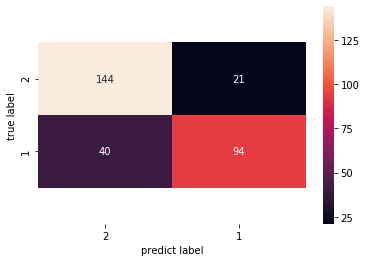

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
labels = [1,2]
cm = confusion_matrix(dataset_labels, y_pred, labels)
ax = sns.heatmap(df_cm, annot=True ,fmt="d") 
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.set_xticklabels([2] + labels)
ax.set_yticklabels([2] + labels)
plt.xlabel('predict label')
plt.ylabel('true label' )
plt.show()

In [21]:
tn, fp, fn, tp = confusion_matrix(dataset_labels, y_pred).ravel()
specificity = tn / (tn+fp)
print(specificity)
sensitivity =  tp / (tp + fn)
print(sensitivity) 

0.8727272727272727
0.7014925373134329
